# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.99:34563 Dashboard: http://10.148.1.99:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [2]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/fsturb/'
run = 'fsturb_4km_0a1000j/'

r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home/c11-data/Test_aponte/fsturb/fsturb_4km_0a1000j/
Found 10 segments
Found 1 grid files
Found 20 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


---

## bulk statistics

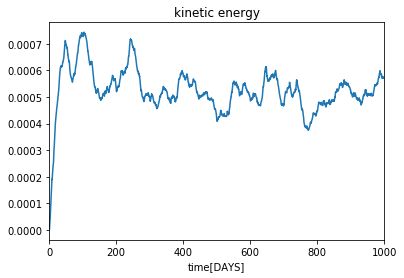

In [25]:
r.stats['KINETIC_ENRG'].plot(title='kinetic energy')

In [49]:
r['surf'].u #.mean(dim=['x_u','time'])

<xarray.DataArray 'u' (time: 1000, s_rho_slice0: 1, y_rho: 722, x_u: 257)>
dask.array<concatenate, shape=(1000, 1, 722, 257), dtype=float32, chunksize=(1, 1, 722, 257), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 1.0 2.0 3.0 4.0 5.0 ... 997.0 998.0 999.0 1e+03
    xi_u          (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    eta_u         (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
  * s_rho_slice0  (s_rho_slice0) float32 -0.01
    time_counter  (time) float64 1.0 2.0 3.0 4.0 5.0 ... 997.0 998.0 999.0 1e+03
Dimensions without coordinates: y_rho, x_u
Attributes:
    long_name:           u-momentum component
    units:               meter second-1
    online_operation:    instant
    interval_operation:  1 d
    interval_write:      1 d
    cell_methods:        time: point

In [54]:
r['surf'].reset_coords().mean(dim=['x_rho','x_u','time'])

<xarray.Dataset>
Dimensions:       (s_rho_slice0: 1, y_rho: 722, y_v: 721)
Coordinates:
  * s_rho_slice0  (s_rho_slice0) float32 -0.01
Dimensions without coordinates: y_rho, y_v
Data variables:
    xi_rho        (y_rho) float32 512000.0 512000.0 ... 512000.0 512000.0
    xi_u          (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    eta_u         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    eta_v         (y_v) float32 dask.array<chunksize=(721,), meta=np.ndarray>
    xi_v          (y_v) float32 dask.array<chunksize=(721,), meta=np.ndarray>
    eta_rho       (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    time_counter  float64 500.5
    ssh           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    T             (s_rho_slice0, y_rho) float32 dask.array<chunksize=(1, 722), meta=np.ndarray>
    u             (s_rho_slice0, y_rho) float32 dask.array<chunksize=(1, 722), meta=np.ndarray>
    v             (s_rho_slice0,

In [29]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

ValueError: y must be either None or one of ('y_rho')

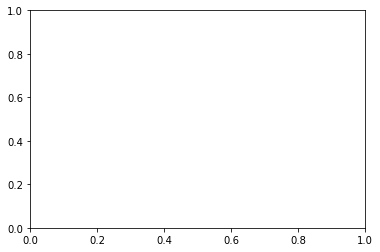

In [42]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='eta_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='eta_v', ax=ax, label='v2')
ax.legend()

In [ ]:
t

In [40]:
toplt = (r['surf'].u**2).mean(dim=['x_u']).persist()
toplt

<xarray.DataArray 'u' (time: 1000, s_rho_slice0: 1, y_rho: 722)>
dask.array<mean_agg-aggregate, shape=(1000, 1, 722), dtype=float32, chunksize=(1, 1, 722), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 1.0 2.0 3.0 4.0 5.0 ... 997.0 998.0 999.0 1e+03
  * s_rho_slice0  (s_rho_slice0) float32 -0.01
    time_counter  (time) float64 1.0 2.0 3.0 4.0 5.0 ... 997.0 998.0 999.0 1e+03
Dimensions without coordinates: y_rho

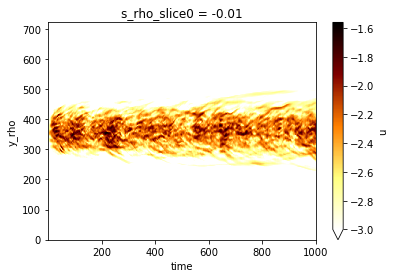

In [63]:
toplt.squeeze().plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape

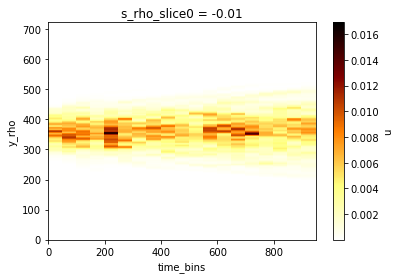

In [72]:
(toplt.groupby_bins('time',np.arange(0,1000,50))
 .mean('time').plot(x='time_bins', y='y_rho', cmap='afmhot_r')
)

AttributeError: 'tuple' object has no attribute 'pcolormesh'

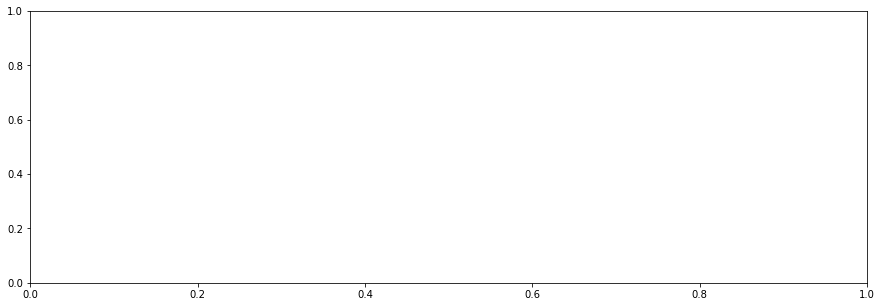

In [41]:
ax = plt.subplots(1,1, figsize=(15,5))
toplt.plot(,ax=ax)

--- 

## pictures

In [ ]:
(r['surf']['u'].sel(time=slice(0,1000,200))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=3, 
               subplot_kws={'aspect':'equal'},
               aspect=.5)
)

In [10]:
r['surf'].time_instant[-1].compute()

<xarray.DataArray 'time_instant' ()>
array(1000.)
Coordinates:
    time_instant  float64 1e+03
    time_counter  float64 1e+03

Exception ignored in: <function Run.__del__ at 0x2aab064fa158>
Traceback (most recent call last):
  File "/home1/datahome/aponte/croco/crocosi/postp.py", line 72, in __del__
    for s in suffix:
NameError: name 'suffix' is not defined


In [24]:
V = ['u', 'v']
ds = r['surf'][V]
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 19 GB


In [26]:
x, y, t = 100, 100, 6*24*20
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

<xarray.Dataset>
Dimensions:       (s_rho_slice0: 1, time: 12527, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * s_rho_slice0  (s_rho_slice0) float32 -0.01
    xi_u          (y_rho, x_u) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.587e+03 1.587e+03
    eta_u         (y_rho, x_u) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    eta_v         (y_v, x_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    xi_v          (y_v, x_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    f             (y_rho, x_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(2880,), meta=np.ndarray>
Dimensions without coordinates: time, x_

In [ ]:
ds = ds.persist()

---

## Spectra: manual comput

---

## Spectra: xrft

---

## Decorrelation: manual apply_ufunc

---

In [73]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli